# **Cargado de archivos**

In [1]:
# =============================================================================
# Configuración optimizada de la sesión de Spark
# =============================================================================
# Esta configuración es más robusta para conjuntos de datos grandes.
# Debe ejecutarse una vez al inicio del notebook.

from pyspark.sql import SparkSession
import os

spark = SparkSession.builder \
    .appName("BlueBikes-Project") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.sql.shuffle.partitions", "200") \
    .config("spark.network.timeout", "800s") \
    .config("spark.executor.heartbeatInterval", "60s") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .config("spark.driver.maxResultSize", "2g") \
    .getOrCreate()

# Establecer variables de entorno para que PySpark funcione correctamente en algunos entornos
import sys
# os.environ["PYSPARK_PYTHON"] = sys.executable
# os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable
os.environ["PYSPARK_PYTHON"] = "python"
os.environ["PYSPARK_DRIVER_PYTHON"] = "python"

In [2]:
# =============================================================================
# Cargar DataFrame procesado desde Google Drive (para Colab)
# =============================================================================
# Esta celda activa tu Google Drive y lee los datos procesados del archivo Parquet almacenado allí.
# Usarlo en el entorno de Google Colab.

from google.colab import drive

print("Intentando montar Google Drive...")
try:
    drive.mount('/content/drive')

    gdrive_path = "/content/drive/MyDrive/BlueBikes_PRJ/df_final_bluebikes_v2.parquet"
    print(f"Cargando datos desde la ruta de Google Drive: {gdrive_path}")

    # Spark leerá la carpeta Parquet directamente
    df_final = spark.read.parquet(gdrive_path)

    print("✅ DataFrame cargado exitosamente desde Google Drive.")

    # Verify the schema and show a few rows
    print("Esquema de DataFrame:")
    df_final.printSchema()

    print("Muestra de los datos cargados:")
    df_final.show(5, truncate=False)

except Exception as e:
    print(f"❌ Error al cargar datos desde Google Drive. Asegúrate de que el archivo exista en '{gdrive_path}'.")
    print(f"Detalles del error: {e}")

Intentando montar Google Drive...
Mounted at /content/drive
Cargando datos desde la ruta de Google Drive: /content/drive/MyDrive/BlueBikes_PRJ/df_final_bluebikes_v2.parquet
✅ DataFrame cargado exitosamente desde Google Drive.
Esquema de DataFrame:
root
 |-- trip_date: date (nullable = true)
 |-- start_station_name: string (nullable = true)
 |-- ride_id: string (nullable = true)
 |-- rideable_type: string (nullable = true)
 |-- started_at: timestamp (nullable = true)
 |-- ended_at: timestamp (nullable = true)
 |-- start_lat: double (nullable = true)
 |-- start_lng: double (nullable = true)
 |-- end_station_name: string (nullable = true)
 |-- end_lat: double (nullable = true)
 |-- end_lng: double (nullable = true)
 |-- member_casual: string (nullable = true)
 |-- duration_sec: long (nullable = true)
 |-- schema_version: string (nullable = true)
 |-- periodo: string (nullable = true)
 |-- started_at_local: timestamp (nullable = true)
 |-- ts_hour: timestamp (nullable = true)
 |-- trip_yea

# **Agregado de Datos para Crear la Serie Temporal**

In [3]:
# Agrupamos los viajes por estación y por hora para contar el número de salidas.
from pyspark.sql.functions import col, count

if df_final:
    print("\nIniciando la agregación de datos por estación y hora...")
    df_demand = df_final.groupBy("start_station_name", "ts_hour") \
                        .agg(count("*").alias("num_departures")) \
                        .orderBy("start_station_name", "ts_hour")

    # Almacenar en caché el resultado para un acceso más rápido en los siguientes pasos
    df_demand.cache()

    print("✅ Agregación completada.")

    # --- 4. Verificación del Resultado ---
    print("\nEsquema del nuevo DataFrame de demanda:")
    df_demand.printSchema()

    print("\nMuestra de los datos de demanda agregados:")
    df_demand.show(10, truncate=False)

    print(f"\nTotal de registros únicos de 'estación-hora' creados: {df_demand.count()}")
    print("\nFASE 1 COMPLETADA: El DataFrame 'df_demand' está listo para la siguiente fase de Ingeniería de Características para series temporales.")


Iniciando la agregación de datos por estación y hora...
✅ Agregación completada.

Esquema del nuevo DataFrame de demanda:
root
 |-- start_station_name: string (nullable = true)
 |-- ts_hour: timestamp (nullable = true)
 |-- num_departures: long (nullable = false)


Muestra de los datos de demanda agregados:
+-------------------+-------------------+--------------+
|start_station_name |ts_hour            |num_departures|
+-------------------+-------------------+--------------+
| Broadway and Cabot|2024-04-29 10:00:00|2             |
| Broadway and Cabot|2024-05-02 14:00:00|1             |
| Broadway and Cabot|2024-05-03 08:00:00|1             |
| Broadway and Cabot|2024-05-04 04:00:00|1             |
| Broadway and Cabot|2024-05-05 04:00:00|1             |
| Broadway and Cabot|2024-05-06 03:00:00|1             |
| Broadway and Cabot|2024-05-07 03:00:00|1             |
| Broadway and Cabot|2024-05-07 09:00:00|1             |
| Broadway and Cabot|2024-05-10 14:00:00|1             |
| Broa

# **Ingeniería de Características para Series Temporales**

In [4]:
# =============================================================================
# PRONÓSTICO DE DEMANDA
# =============================================================================
# Objetivo: Enriquecer el DataFrame de demanda agregada con características
#           temporales, de retraso (lag) y de ventana (rolling) para preparar
#           los datos para el modelado de pronósticos.
# =============================================================================

from pyspark.sql.functions import col, year, month, dayofweek, hour, lag, avg, when, to_date, lit, coalesce, sin, cos
from pyspark.sql.window import Window
import numpy as np
import holidays
import datetime as dt
import pyspark.sql.functions as F # Import F

# --- 1. Re-extraer Características Temporales del DataFrame Agregado ---
# Mantenemos las características temporales clave que serán útiles para el modelo.
# Estas se derivan de la columna 'ts_hour' que creamos en la fase anterior.
print("Iniciando la creación de características temporales...")

df_demand_features = df_demand \
    .withColumn('trip_date', to_date(col('ts_hour'))) \
    .withColumn('trip_year', year(col('ts_hour'))) \
    .withColumn('trip_month', month(col('ts_hour'))) \
    .withColumn('trip_day_of_week', dayofweek(col('ts_hour'))) \
    .withColumn('trip_hour', hour(col('ts_hour')))

# Creamos de nuevo las características cíclicas para la hora y el día de la semana
df_demand_features = df_demand_features \
    .withColumn('hour_sin', F.sin(2 * np.pi * col('trip_hour') / 24)) \
    .withColumn('hour_cos', F.cos(2 * np.pi * col('trip_hour') / 24)) \
    .withColumn('day_of_week_sin', F.sin(2 * np.pi * col('trip_day_of_week') / 7)) \
    .withColumn('day_of_week_cos', F.cos(2 * np.pi * col('trip_day_of_week') / 7))

print("✅ Características temporales y cíclicas creadas.")

# --- 2. Añadir Característica de Feriados (is_holiday) ---
print("\nAñadiendo información de feriados...")

# A) Obtener el rango de años presentes en los datos
min_max_years = df_demand_features.agg(F.min("trip_year").alias("min_y"), F.max("trip_year").alias("max_y")).first()
years = list(range(min_max_years["min_y"], min_max_years["max_y"] + 1))

# B) Construir el calendario de feriados para Massachusetts, USA
us_ma_holidays = holidays.US(subdiv="MA", years=years)
holiday_dates = sorted(us_ma_holidays.keys())

# C) Crear un DataFrame de Spark con las fechas de los feriados
holiday_df = spark.createDataFrame([(d,) for d in holiday_dates], ["trip_date"]) \
                  .withColumn("is_holiday", lit(1))

# D) Unir la información de feriados al DataFrame principal
df_demand_features = df_demand_features.join(holiday_df, on="trip_date", how="left") \
                                       .withColumn("is_holiday", coalesce(col("is_holiday"), lit(0)))

print("✅ Característica 'is_holiday' añadida.")


# --- 3. Crear Características de Retraso (Lag) y Ventana (Window) ---
print("\nCreando características de retraso y de ventana móvil...")

# Definimos una 'ventana' de tiempo para cada estación.
# Esto es crucial para asegurar que los cálculos de lag y promedios se hagan por separado para cada estación.
window_spec_station = Window.partitionBy("start_station_name").orderBy("ts_hour")

# A) Características de Retraso (Lag Features)
# ¿Cuál fue la demanda en esta estación hace 1 hora y hace 24 horas?
df_demand_features = df_demand_features \
    .withColumn("departures_1hr_ago", lag("num_departures", 1).over(window_spec_station)) \
    .withColumn("departures_24hr_ago", lag("num_departures", 24).over(window_spec_station))

# B) Características de Ventana (Window Features)
# ¿Cuál fue el promedio de salidas en las últimas 3 horas para esta estación?
# rowsBetween(-3, -1) calcula el promedio de las 3 filas anteriores a la actual.
window_spec_rolling_3hr = window_spec_station.rowsBetween(-3, -1)
df_demand_features = df_demand_features \
    .withColumn("avg_departures_last_3hrs", avg("num_departures").over(window_spec_rolling_3hr))

# C) Limpieza de Nulos
# Las funciones de ventana crean nulos al inicio de la serie temporal de cada estación (ej. no hay datos para "hace 24 horas" en el primer día).
# Los rellenamos con 0, asumiendo que no hubo demanda previa.
df_demand_features = df_demand_features.fillna(0, subset=[
    "departures_1hr_ago",
    "departures_24hr_ago",
    "avg_departures_last_3hrs"
])

print("✅ Características de retraso y ventana móvil creadas y limpiadas.")

# --- 4. Platzhalter für externe Daten (z. B. Wetter) ---
# La unión de datos meteorológicos (temperatura, precipitación) mejoraría enormemente la precisión del modelo.
# El siguiente bloque es un ejemplo conceptual de cómo se haría esto.
# En un proyecto real, se obtendrían datos de una API meteorológica y se unirían por fecha y hora.
print("\n(Opcional) Platzhalter para la unión de datos externos como el clima.")
#
# # DataFrame de ejemplo con datos meteorológicos (reemplazar con datos reales)
# weather_data = [
#     ("2024-09-01 10:00:00", 25.5, 0.0),
#     ("2024-09-01 11:00:00", 26.1, 0.0),
#     ("2024-09-01 12:00:00", 26.8, 5.2)
# ]
# weather_df = spark.createDataFrame(weather_data, ["ts_hour", "temperature_celsius", "precipitation_mm"])
# weather_df = weather_df.withColumn("ts_hour", to_timestamp(col("ts_hour")))
#
# # Unir con el DataFrame de demanda
# df_demand_final_features = df_demand_features.join(weather_df, on="ts_hour", how="left")
#

# --- 5. Verificación Final ---
print("\nEsquema del DataFrame final con todas las características:")
df_demand_features.printSchema()

print("\nMuestra de los datos finales:")
df_demand_features.show(10, truncate=False)

# Almacenar en caché el resultado final para la fase de modelado
df_demand_features.cache()
print(f"\nTotal de registros en el DataFrame final de características: {df_demand_features.count()}")

# --- 6. Guardar el DataFrame con Características en Parquet ---
# Es una buena práctica guardar este DataFrame enriquecido para no tener que repetir
# este costoso proceso de ingeniería de características.
try:
    gdrive_path_features = "/content/drive/MyDrive/BlueBikes_PRJ/df_demand_features.parquet"
    print(f"\nIntentando guardar el DataFrame con características en: {gdrive_path_features}")
    df_demand_features.write.mode("overwrite").parquet(gdrive_path_features)
    print("✅ DataFrame con características guardado exitosamente en Google Drive.")
except Exception as e:
    print(f"❌ Error al guardar el DataFrame con características: {e}")


print("\nFASE 2 COMPLETADA: El DataFrame 'df_demand_features' está listo para el modelado.")

Iniciando la creación de características temporales...
✅ Características temporales y cíclicas creadas.

Añadiendo información de feriados...
✅ Característica 'is_holiday' añadida.

Creando características de retraso y de ventana móvil...
✅ Características de retraso y ventana móvil creadas y limpiadas.

(Opcional) Platzhalter para la unión de datos externos como el clima.

Esquema del DataFrame final con todas las características:
root
 |-- trip_date: date (nullable = true)
 |-- start_station_name: string (nullable = true)
 |-- ts_hour: timestamp (nullable = true)
 |-- num_departures: long (nullable = false)
 |-- trip_year: integer (nullable = true)
 |-- trip_month: integer (nullable = true)
 |-- trip_day_of_week: integer (nullable = true)
 |-- trip_hour: integer (nullable = true)
 |-- hour_sin: double (nullable = true)
 |-- hour_cos: double (nullable = true)
 |-- day_of_week_sin: double (nullable = true)
 |-- day_of_week_cos: double (nullable = true)
 |-- is_holiday: integer (nullabl

# **Modelado y Evaluación**

In [7]:
# =============================================================================
# PRONÓSTICO DE DEMANDA - FASE 3 (VERSIÓN MEJORADA CON HYPERPARAMETER TUNING)
# =============================================================================
# Objetivo: Utilizar Cross-Validation para encontrar los mejores hiperparámetros
#           para el modelo GBT, entrenarlo y evaluar su rendimiento.
# =============================================================================

from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder # ¡Nuevas importaciones!
import os
import datetime as dt
import pyspark.sql.functions as F

# --- 1. Configuración de la Sesión de Spark y Carga de Datos ---
print("Configurando la sesión de Spark...")
spark = SparkSession.builder \
    .appName("BlueBikes-Demand-Modeling-Tuning") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.sql.shuffle.partitions", "200") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .getOrCreate()

os.environ["PYSPARK_PYTHON"] = "python"
os.environ["PYSPARK_DRIVER_PYTHON"] = "python"
print("✅ Sesión de Spark configurada.")

df_demand_features = None
try:
    from google.colab import drive
    print("\nIntentando montar Google Drive...")
    drive.mount('/content/drive')

    gdrive_path_features = "/content/drive/MyDrive/BlueBikes_PRJ/df_demand_features.parquet"
    print(f"Cargando datos con características desde: {gdrive_path_features}")

    df_demand_features = spark.read.parquet(gdrive_path_features)
    print("✅ DataFrame con características cargado exitosamente.")
    print(f"Total de registros cargados: {df_demand_features.count()}")

except Exception as e:
    print(f"❌ Error al cargar datos desde Google Drive: {e}")


# --- 2. Preparación de Características para el Modelo ---
if df_demand_features is not None:
    print("\nPreparando las características para el modelo...")
    label_col = "num_departures"
    station_indexer = StringIndexer(inputCol="start_station_name", outputCol="station_index", handleInvalid="keep")
    feature_cols = [
        'station_index', 'trip_year', 'trip_month', 'trip_day_of_week', 'trip_hour',
        'is_holiday', 'hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos',
        'departures_1hr_ago', 'departures_24hr_ago', 'avg_departures_last_3hrs'
    ]
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
    print(f"✅ Características listas para ser ensambladas.")

    # --- 3. División de Datos para Series Temporales (Train/Test Split) ---
    print("\nDividiendo los datos en conjuntos de entrenamiento y prueba por fecha...")
    max_date = df_demand_features.agg(F.max("trip_date")).first()[0]
    cutoff_date = max_date - dt.timedelta(days=30)
    train_data = df_demand_features.filter(col("trip_date") <= cutoff_date)
    test_data = df_demand_features.filter(col("trip_date") > cutoff_date)
    train_data.cache()
    test_data.cache()
    print(f"Fecha de corte para la división: {cutoff_date}")
    print(f"Registros de entrenamiento: {train_data.count()}, Registros de prueba: {test_data.count()}")
    print("✅ División de datos completada.")

    # --- 4. Definición del Modelo y Pipeline ---
    gbt = GBTRegressor(featuresCol="features", labelCol=label_col, maxBins=1000, seed=42)
    pipeline = Pipeline(stages=[station_indexer, assembler, gbt])

    # --- 5. ¡NUEVO! Configuración de Hyperparameter Tuning con CrossValidator ---
    print("\nConfigurando la validación cruzada para el ajuste de hiperparámetros...")
    # Definimos la parrilla de parámetros a probar.
    # Para acceder a un parámetro del GBT dentro del pipeline, usamos el nombre de la etapa ("gbt")
    paramGrid = ParamGridBuilder() \
        .addGrid(gbt.maxDepth, [5, 10]) \
        .addGrid(gbt.maxIter, [10, 20]) \
        .build()

    # Usaremos el Error Absoluto Medio (MAE) para evaluar qué combinación de parámetros es la mejor.
    evaluator_mae = RegressionEvaluator(labelCol=label_col, predictionCol="prediction", metricName="mae")

    # Configuramos el CrossValidator. Usaremos 3 pliegues (folds).
    crossval = CrossValidator(estimator=pipeline,
                              estimatorParamMaps=paramGrid,
                              evaluator=evaluator_mae,
                              numFolds=3)

    # --- 6. Entrenamiento del Modelo con CrossValidator ---
    print("\nIniciando el entrenamiento con CrossValidator... (Esto puede tomar más tiempo)")
    cv_model = crossval.fit(train_data)
    print("✅ Modelo entrenado y ajustado exitosamente.")

    # Obtenemos el mejor modelo encontrado por el proceso de validación cruzada
    bestModel = cv_model.bestModel

    # Mostramos los mejores parámetros encontrados
    best_max_depth = bestModel.stages[-1].getMaxDepth()
    best_max_iter = bestModel.stages[-1].getMaxIter()
    print(f"\nMejores parámetros encontrados: maxDepth={best_max_depth}, maxIter={best_max_iter}")

    # --- 7. Evaluación del Mejor Modelo ---
    print("\nEvaluando el rendimiento del mejor modelo en el conjunto de prueba...")
    predictions = bestModel.transform(test_data)

    evaluator_rmse = RegressionEvaluator(labelCol=label_col, predictionCol="prediction", metricName="rmse")
    evaluator_r2 = RegressionEvaluator(labelCol=label_col, predictionCol="prediction", metricName="r2")

    mae = evaluator_mae.evaluate(predictions)
    rmse = evaluator_rmse.evaluate(predictions)
    r2 = evaluator_r2.evaluate(predictions)

    print("\n--- Métricas de Rendimiento del Modelo de Pronóstico (Ajustado) ---")
    print(f"Error Absoluto Medio (MAE): {mae:.4f}")
    print(f"Raíz del Error Cuadrático Medio (RMSE): {rmse:.4f}")
    print(f"Coeficiente de Determinación (R²): {r2:.4f}")
    print("-------------------------------------------------------------------")

    print("\nMuestra de predicciones vs. valores reales:")
    predictions.select("start_station_name", "ts_hour", "num_departures", "prediction").show(15, truncate=False)

    # --- 8. GUARDAR EL MEJOR MODELO ENTRENADO ---
    try:
        model_path = "/content/drive/MyDrive/BlueBikes_PRJ/gbt_demand_forecasting_model_tuned"
        print(f"\nIntentando guardar el mejor modelo en: {model_path}")
        bestModel.write().overwrite().save(model_path)
        print("✅ Mejor modelo guardado exitosamente.")
    except Exception as e:
        print(f"❌ Error al guardar el modelo: {e}")

    train_data.unpersist()
    test_data.unpersist()

    print("\nFASE 3 COMPLETADA: El modelo ha sido entrenado con ajuste de hiperparámetros, evaluado y guardado.")

Configurando la sesión de Spark...
✅ Sesión de Spark configurada.

Intentando montar Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Cargando datos con características desde: /content/drive/MyDrive/BlueBikes_PRJ/df_demand_features.parquet
✅ DataFrame con características cargado exitosamente.
Total de registros cargados: 9369036

Preparando las características para el modelo...
✅ Características listas para ser ensambladas.

Dividiendo los datos en conjuntos de entrenamiento y prueba por fecha...
Fecha de corte para la división: 2025-05-31
Registros de entrenamiento: 9205965, Registros de prueba: 163071
✅ División de datos completada.

Configurando la validación cruzada para el ajuste de hiperparámetros...

Iniciando el entrenamiento con CrossValidator... (Esto puede tomar más tiempo)
✅ Modelo entrenado y ajustado exitosamente.

Mejores parámetros encontrados: maxDepth=10, maxIter=20

Evalua

# **Generación de Información Accionable**

In [8]:
# =============================================================================
# Objetivo: Utilizar el modelo entrenado para pronosticar la demanda de bicicletas
#           en las próximas horas y generar una tabla de alertas para el equipo
#           de operaciones.
# =============================================================================

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lit, unix_timestamp, avg, round as spark_round, when, to_date, year, month, dayofweek, hour, coalesce, sin, cos
from pyspark.sql.window import Window
from pyspark.ml import PipelineModel
import datetime as dt
import numpy as np
import pandas as pd
import pyspark.sql.functions as F

# --- 1. Configuración y Carga de Artefactos ---
print("Configurando la sesión de Spark...")
spark = SparkSession.builder \
    .appName("BlueBikes-Demand-Insights") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .getOrCreate()
print("✅ Sesión de Spark configurada.")

df_demand_features = None
model = None
try:
    from google.colab import drive
    print("\nIntentando montar Google Drive...")
    drive.mount('/content/drive', force_remount=True)

    # Cargar datos con características
    gdrive_path_features = "/content/drive/MyDrive/BlueBikes_PRJ/df_demand_features.parquet"
    print(f"Cargando datos con características desde: {gdrive_path_features}")
    df_demand_features = spark.read.parquet(gdrive_path_features)
    print("✅ DataFrame con características cargado exitosamente.")

    # Cargar el modelo entrenado (¡No re-entrenar!)
    model_path = "/content/drive/MyDrive/BlueBikes_PRJ/gbt_demand_forecasting_model"
    print(f"Cargando el modelo pre-entrenado desde: {model_path}")
    model = PipelineModel.load(model_path)
    print("✅ Modelo listo para generar pronósticos.")

except Exception as e:
    print(f"❌ Error al cargar datos o el modelo: {e}")

# --- 2. Calcular Promedios Históricos de Demanda ---
if df_demand_features is not None and model is not None:
    print("\nCalculando promedios históricos de demanda por estación, día y hora...")
    df_historical_avg = df_demand_features.groupBy("start_station_name", "trip_day_of_week", "trip_hour") \
        .agg(avg("num_departures").alias("historical_avg_departures")) \
        .withColumn("historical_avg_departures", spark_round(col("historical_avg_departures"), 2))

    df_historical_avg.cache()
    print("✅ Promedios históricos calculados.")

    # --- 3. Pronóstico Iterativo para las Próximas Horas ---
    print("\nIniciando pronóstico iterativo para las próximas 6 horas...")

    future_hours = 6
    # Empezamos con los últimos datos reales que necesitamos para los features de lag
    last_timestamp = df_demand_features.agg(F.max("ts_hour")).first()[0]
    print(f"Última hora con datos reales: {last_timestamp}")

    # Necesitamos al menos 24 horas de datos para calcular 'departures_24hr_ago'
    df_history = df_demand_features.filter(col("ts_hour") > (last_timestamp - dt.timedelta(hours=25)))

    stations_df = df_demand_features.select("start_station_name").distinct()

    all_future_predictions = []

    for i in range(future_hours):
        current_prediction_ts = last_timestamp + dt.timedelta(hours=i + 1)
        print(f"  -> Pronosticando para la hora: {current_prediction_ts}...")

        # A) Crear el esqueleto para la hora actual que queremos predecir
        df_future_scaffold = stations_df.withColumn("ts_hour", lit(current_prediction_ts).cast("timestamp"))

        # B) Combinar la historia con el esqueleto de la hora a predecir
        df_combined = df_history.unionByName(df_future_scaffold, allowMissingColumns=True)

        # C) Generar características para el esqueleto
        window_spec_station = Window.partitionBy("start_station_name").orderBy("ts_hour")

        df_future_with_features = df_combined \
            .withColumn('trip_date', to_date(col('ts_hour'))) \
            .withColumn('trip_year', year(col('ts_hour'))) \
            .withColumn('trip_month', month(col('ts_hour'))) \
            .withColumn('trip_day_of_week', dayofweek(col('ts_hour'))) \
            .withColumn('trip_hour', hour(col('ts_hour'))) \
            .withColumn('is_holiday', coalesce(col("is_holiday"), lit(0))) \
            .withColumn('hour_sin', sin(2 * np.pi * col('trip_hour') / 24)) \
            .withColumn('hour_cos', cos(2 * np.pi * col('trip_hour') / 24)) \
            .withColumn('day_of_week_sin', sin(2 * np.pi * col('trip_day_of_week') / 7)) \
            .withColumn('day_of_week_cos', cos(2 * np.pi * col('trip_day_of_week') / 7)) \
            .withColumn("departures_1hr_ago", lag("num_departures", 1).over(window_spec_station)) \
            .withColumn("departures_24hr_ago", lag("num_departures", 24).over(window_spec_station)) \
            .withColumn("avg_departures_last_3hrs", avg("num_departures").over(window_spec_station.rowsBetween(-3, -1))) \
            .fillna(0, subset=["departures_1hr_ago", "departures_24hr_ago", "avg_departures_last_3hrs"])

        # D) Aislar solo las filas que necesitamos predecir
        df_to_predict = df_future_with_features.filter(col("ts_hour") == current_prediction_ts)

        # E) Hacer la predicción
        current_predictions = model.transform(df_to_predict)

        # F) Preparar el resultado de la predicción para la siguiente iteración
        # Redondeamos la predicción y evitamos negativos
        df_predicted_results = current_predictions.select(
            "start_station_name",
            "ts_hour",
            when(col("prediction") < 0, 0).otherwise(col("prediction")).alias("num_departures")
        )

        # G) Actualizar el historial con los nuevos resultados predichos
        df_history = df_history.unionByName(df_predicted_results, allowMissingColumns=True)

        all_future_predictions.append(current_predictions)

    print("✅ Pronóstico iterativo completado.")

    # --- 4. Unir Todas las Predicciones y Generar Alertas ---
    print("\nGenerando el tablero de operaciones final...")

    # Unir todos los DataFrames de predicción de cada hora
    from functools import reduce
    df_final_predictions = reduce(lambda df1, df2: df1.unionByName(df2), all_future_predictions)

    df_insights = df_final_predictions.join(
        df_historical_avg,
        on=["start_station_name", "trip_day_of_week", "trip_hour"],
        how="left"
    )

    df_insights = df_insights.withColumn("prediction", spark_round(col("prediction"), 2)) \
        .withColumn(
            "Alerta",
            when(col("prediction") > (col("historical_avg_departures") * 1.5), "ALTA DEMANDA (Riesgo de vaciarse)")
            .when(col("prediction") < (col("historical_avg_departures") * 0.5), "BAJA DEMANDA (Riesgo de llenarse)")
            .otherwise("Demanda Normal")
        )

    df_dashboard = df_insights.select(
        col("ts_hour").alias("Hora_Pronostico"),
        col("start_station_name").alias("Estacion"),
        when(col("prediction") < 0, 0).otherwise(col("prediction")).alias("Salidas_Pronosticadas"),
        col("historical_avg_departures").alias("Promedio_Historico"),
        "Alerta"
    ).orderBy(col("Hora_Pronostico"), col("Alerta").desc(), col("Salidas_Pronosticadas").desc())

    print("✅ Pronósticos y alertas generados.")

    # --- 5. Mostrar el Resultado Final ---
    print("\n--- TABLERO DE OPERACIONES: PRONÓSTICO DE DEMANDA DE BICICLETAS ---")
    df_dashboard.show(40, truncate=False)

    print("\nFASE 4 COMPLETADA: Se ha generado un pronóstico accionable para el equipo de operaciones.")
else:
    print("\n❌ No se pudo ejecutar la fase 4 porque el DataFrame de características o el modelo no se cargaron correctamente.")

Configurando la sesión de Spark...
✅ Sesión de Spark configurada.

Intentando montar Google Drive...
Mounted at /content/drive
Cargando datos con características desde: /content/drive/MyDrive/BlueBikes_PRJ/df_demand_features.parquet
✅ DataFrame con características cargado exitosamente.
Cargando el modelo pre-entrenado desde: /content/drive/MyDrive/BlueBikes_PRJ/gbt_demand_forecasting_model
✅ Modelo listo para generar pronósticos.

Calculando promedios históricos de demanda por estación, día y hora...
✅ Promedios históricos calculados.

Iniciando pronóstico iterativo para las próximas 6 horas...
Última hora con datos reales: 2025-06-30 19:00:00
  -> Pronosticando para la hora: 2025-06-30 20:00:00...
  -> Pronosticando para la hora: 2025-06-30 21:00:00...
  -> Pronosticando para la hora: 2025-06-30 22:00:00...
  -> Pronosticando para la hora: 2025-06-30 23:00:00...
  -> Pronosticando para la hora: 2025-07-01 00:00:00...
  -> Pronosticando para la hora: 2025-07-01 01:00:00...
✅ Pronóstico

# **Visualización del Pronóstico (Prueba de Concepto)**

Preparando los datos para la visualización...
Convirtiendo a Pandas los datos para la hora: 2025-06-30 20:00:00
✅ Datos listos. Generando el gráfico...


/tmp/ipython-input-3270071488.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Salidas_Pronosticadas",


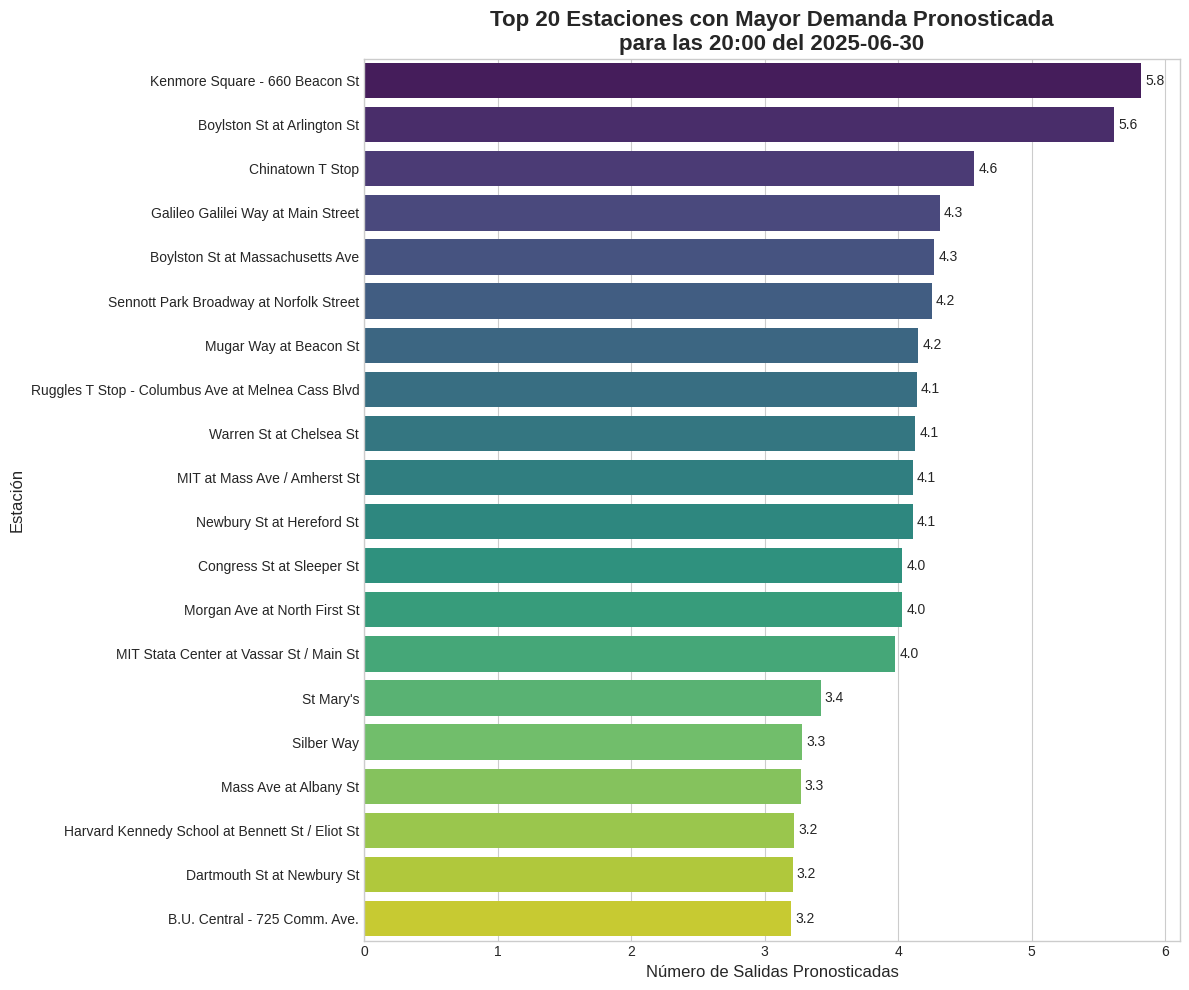


✅ Visualización generada exitosamente.


In [9]:
# =============================================================================
# Visualización del Pronóstico (Prueba de Concepto)
# =============================================================================
# Objetivo: Crear una visualización estática para el tablero de operaciones,
#           mostrando las estaciones con la mayor demanda pronosticada
#           para la primera hora del pronóstico.
# =============================================================================

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- 1. Preparar los Datos para Visualizar ---
print("Preparando los datos para la visualización...")

# El DataFrame 'df_dashboard' ya existe de la celda anterior.
# Nos enfocaremos en la primera hora del pronóstico.
if 'df_dashboard' in locals():

    # Obtenemos la primera estampa de tiempo del pronóstico
    first_forecast_hour = df_dashboard.select("Hora_Pronostico").first()[0]

    # Filtramos el dashboard para esa hora, tomamos las 20 estaciones con mayor pronóstico
    df_plot_data = df_dashboard.filter(col("Hora_Pronostico") == first_forecast_hour) \
                               .orderBy(col("Salidas_Pronosticadas").desc()) \
                               .limit(20)

    # Convertimos el resultado a un DataFrame de Pandas para poder graficarlo
    # .toPandas() es adecuado aquí porque hemos limitado los datos a solo 20 filas.
    print(f"Convirtiendo a Pandas los datos para la hora: {first_forecast_hour}")
    pd_plot_data = df_plot_data.toPandas()

    # --- 2. Crear la Visualización ---
    print("✅ Datos listos. Generando el gráfico...")
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(12, 10))

    # Usamos Seaborn para un gráfico de barras horizontal
    sns.barplot(x="Salidas_Pronosticadas",
                y="Estacion",
                data=pd_plot_data,
                palette="viridis",
                ax=ax)

    # --- 3. Personalizar el Gráfico ---
    ax.set_title(f'Top 20 Estaciones con Mayor Demanda Pronosticada\npara las {first_forecast_hour.strftime("%H:%M del %Y-%m-%d")}',
                 fontsize=16,
                 fontweight='bold')
    ax.set_xlabel('Número de Salidas Pronosticadas', fontsize=12)
    ax.set_ylabel('Estación', fontsize=12)

    # Añadir etiquetas de valor en cada barra para mayor claridad
    for container in ax.containers:
        ax.bar_label(container, fmt='%.1f', padding=3)

    plt.tight_layout()
    plt.show()

    print("\n✅ Visualización generada exitosamente.")

else:
    print("❌ El DataFrame 'df_dashboard' no fue encontrado. Asegúrate de ejecutar la celda anterior primero.")